In [32]:
import numpy as np
import pandas as pd
import emcee 
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn import tree
from sklearn.model_selection import cross_val_score
import re

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import corner

In [2]:
DF = pd.read_table('simulations.dat', sep='\t')
DF['age'] = DF['age'] / 10**9
DF.head()

,id,M,Y,Z,alpha,diffusion,age,beta,Teff,L,...,r01_43,r13_44,r10_43,nu_0_45,nu_2_44,r01_44,nu_3_8,nu_2_9,nu_3_44,nu_2_8
0,20001,0.776883,0.285652,0.007474,0.720276,1,8.398173,-0.025153,5022.223586,0.546163,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20002,0.811883,0.225652,0.015805,2.220276,1,6.198423,0.024847,4830.176155,0.270065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20003,0.741883,0.265652,0.003534,1.220276,1,10.597923,-0.075153,5530.540668,0.533502,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20004,0.759383,0.235652,0.005139,1.970276,1,5.098548,-0.050153,5324.783056,0.351822,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20007,0.724383,0.295652,0.010868,1.470276,1,7.298298,0.099847,5081.494960,0.336307,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
DF.shape

(12720, 300)

In [4]:
KIC = pd.read_table('../regression/perturb/bigG/7970740_perturb.dat')
KIC = KIC.drop(['Dnu0', 'dnu02', 'r02', 'r01', 'r10'], axis=1)
KIC = KIC.drop([i for i in KIC.columns 
    if re.search('nu_|r01_', i)], axis=1)
KIC_columns = KIC.columns.values
KIC_columns[1] = 'Fe_H'
KIC.columns = KIC_columns
KIC.head()

,Teff,Fe_H,r02_17,r02_18,r02_19,r02_20,r02_21,r02_22,r02_23,r02_24,...,r10_19,r10_20,r10_21,r10_22,r10_23,r10_24,r10_25,r10_26,r10_27,r10_28
0,5309.000000,-0.540000,0.063186,0.056338,0.054542,0.055206,0.049283,0.049298,0.052405,0.036912,...,0.015446,0.015210,0.014888,0.014634,0.014336,0.015857,0.014204,0.010339,0.007882,0.019809
1,5406.247480,-0.572623,0.064753,0.057509,0.054785,0.056270,0.049662,0.048558,0.050471,0.036498,...,0.015442,0.015770,0.014949,0.014335,0.014835,0.015585,0.014184,0.010739,0.002031,0.019091
2,5291.495691,-0.513386,0.062448,0.055563,0.054344,0.056732,0.049226,0.049792,0.050888,0.037943,...,0.015297,0.015168,0.014699,0.014357,0.013725,0.016313,0.014485,0.009978,0.005982,0.018987
3,5326.634508,-0.440346,0.069188,0.052609,0.054532,0.053740,0.048868,0.048610,0.054871,0.034841,...,0.015781,0.015021,0.014749,0.014997,0.013261,0.014480,0.014027,0.011441,0.010553,0.019370
4,5274.490584,-0.492826,0.063603,0.056196,0.056307,0.054735,0.048241,0.047175,0.052728,0.041067,...,0.015662,0.015422,0.015030,0.014258,0.013659,0.016100,0.015520,0.011253,0.012393,0.028254


In [5]:
y_star = KIC.iloc[0]
y_star

Teff      5309.000000
Fe_H        -0.540000
r02_17       0.063186
r02_18       0.056338
r02_19       0.054542
r02_20       0.055206
r02_21       0.049283
r02_22       0.049298
r02_23       0.052405
r02_24       0.036912
r02_25       0.035124
r02_26       0.028170
r02_27       0.014598
r02_28       0.034549
r02_29       0.030393
r10_16       0.020654
r10_17       0.019698
r10_18       0.018950
r10_19       0.015446
r10_20       0.015210
r10_21       0.014888
r10_22       0.014634
r10_23       0.014336
r10_24       0.015857
r10_25       0.014204
r10_26       0.010339
r10_27       0.007882
r10_28       0.019809
Name: 0, dtype: float64

[7.7000000000e+01 1.0000000000e-01 3.9029146453e-03 2.1725166110e-03
 1.4763450735e-03 1.0333801995e-03 1.1141153559e-03 9.9657954298e-04
 1.5794116586e-03 3.0378212737e-03 4.6829660573e-03 6.9970515064e-03
 5.1684757992e-03 7.7142395021e-03 8.8689859465e-03 8.2823371490e-04
 5.6268399444e-04 4.4734607701e-04 4.0459075105e-04 4.5440933645e-04
 5.3669735521e-04 5.7708904568e-04 8.9493725612e-04 1.2624834117e-03
 1.7150952707e-03 2.5820145538e-03 3.9392679640e-03 5.1059887744e-03]


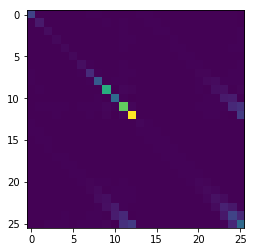

In [6]:
Sigma = np.cov(KIC.iloc[:,2:].T)
Sigma = np.vstack([np.zeros(Sigma.shape[0]), np.zeros(Sigma.shape[0]), Sigma])
Sigma = np.insert(Sigma, 0, np.zeros(Sigma.shape[0]), axis=1)
Sigma = np.insert(Sigma, 0, np.zeros(Sigma.shape[0]), axis=1)
Sigma[0,0] = 77**2
Sigma[1,1] = 0.1**2

np.set_printoptions(precision=10)
print(np.sqrt(np.diag(Sigma)))

plt.imshow(Sigma[2:,2:], interpolation='nearest')
plt.show()

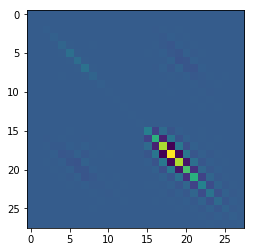

In [7]:
Sigma_inv = np.linalg.inv(Sigma)
Sigma_inv

plt.imshow(Sigma_inv, interpolation='nearest')
plt.show()

In [8]:
Sigma_inv.shape

(28, 28)

In [9]:
# train a forest to learn Teff, FeH, nu_max, Dnu0, dnu02 = f(age, M, Y, Z, alpha, overshoot, undershoot, diffusion)
y_columns = KIC.columns.tolist() #['Teff', 'Fe_H', 'nu_max', 'Dnu0', 'dnu02', 'r02', 'r01', 'r10']
X_columns = ['age', 'M', 'Y', 'Z', 'alpha', 'beta']
X_labels = [r'$\tau$', "$M$", "$Y$", "$Z$", r'$\alpha$', r'$\beta$']
#data_ = DF.loc[:,list(set(X_columns+y_columns))].dropna()
data_ = DF.loc[:,X_columns+y_columns].dropna()
data_.shape

(9206, 34)

In [10]:
X = data_.loc[:, X_columns]
X.head()

,age,M,Y,Z,alpha,beta
0,8.398173,0.776883,0.285652,0.007474,0.720276,-0.025153
2,10.597923,0.741883,0.265652,0.003534,1.220276,-0.075153
4,7.298298,0.724383,0.295652,0.010868,1.470276,0.099847
5,8.948111,0.733133,0.220652,0.004262,0.845276,0.087347
7,11.147861,0.838133,0.240652,0.009013,1.345276,0.037347


In [11]:
ys = data_.loc[:, [i for i in y_columns if i not in X_columns]]
ys.head()

,Teff,Fe_H,r02_17,r02_18,r02_19,r02_20,r02_21,r02_22,r02_23,r02_24,...,r10_19,r10_20,r10_21,r10_22,r10_23,r10_24,r10_25,r10_26,r10_27,r10_28
0,5022.223586,-0.490474,0.078714,0.076353,0.073776,0.071417,0.068856,0.066595,0.064218,0.062057,...,0.027489,0.025164,0.024356,0.022492,0.021573,0.020378,0.019242,0.018492,0.017306,0.016905
2,5530.540668,-0.796330,0.069752,0.066596,0.063632,0.060687,0.058197,0.055656,0.053445,0.051366,...,0.019706,0.019338,0.017466,0.016923,0.016058,0.015088,0.015102,0.014103,0.014194,0.013571
4,5081.494960,-0.234200,0.068950,0.066202,0.063436,0.061174,0.058782,0.056601,0.054814,0.052832,...,0.020414,0.018690,0.017891,0.018260,0.016495,0.016631,0.016484,0.014804,0.015465,0.014555
5,4966.956239,-0.741142,0.069361,0.066217,0.063178,0.060358,0.057819,0.055288,0.053120,0.050975,...,0.019748,0.018927,0.017172,0.016857,0.015553,0.015067,0.014783,0.013872,0.014243,0.013244
7,5409.063014,-0.406669,0.051582,0.047466,0.043100,0.039070,0.035389,0.031672,0.028385,0.025322,...,0.022608,0.020189,0.015852,0.014096,0.011631,0.008566,0.007720,0.005432,0.003902,0.003571


In [44]:
forest = RandomForestRegressor(n_estimators=8)
print(cross_val_score(forest, X, ys, cv=3))
forest.fit(X, ys)
#forest.oob_score_

[0.9723 0.9736 0.9747]


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=8, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [ ]:
#forest = tree.DecisionTreeRegressor(
#    n_estimators=8,
#    n_jobs=1,
#    oob_score=1, bootstrap=1)
#forest.fit(X, ys)
#forest.oob_score_

In [39]:
#forest = RandomForestRegressor(n_estimators=16)
#chi2s = [-np.log10(np.dot(np.dot(y-y_star, Sigma_inv), y-y_star)/2) for idx, y in ys.iterrows()]
#chi2s = [-np.log(np.dot(np.dot(y-y_star, Sigma_inv), y-y_star)/2) for idx, y in ys.iterrows()]
#print(cross_val_score(forest, X, ys, cv=3))
#forest.fit(X, chi2s)
#forest.oob_score_

[0.9758 0.9776 0.9786]


In [45]:
X_max = X.max()
X_min = X.min()

def lnprior(theta):
    if any(theta > X_max) or any(theta < X_min): #X.max()
        return -np.inf
    return 0.0

def lnlike(theta):
    y = forest.predict([theta])[0]
    resid = y-y_star
    chi2 = np.log(np.dot(np.dot(resid, Sigma_inv), resid))
    return(-chi2/2)
    #return forest.predict([theta])[0]

def lnprob(theta):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)

In [46]:
theta = [9.9, 0.75408, 0.258478, 0.005, 1.85, -0.0017]

lnprob(theta)

-2.7240912276571105

In [49]:
ndim, nwalkers = 6, 20
pos = [[10., 0.77, 0.26, 0.005, 1.8, 0.] + 1e-3*np.random.randn(ndim) 
    for i in range(nwalkers)]

np.set_printoptions(precision=4, linewidth=100)
pos

[array([ 9.9995e+00,  7.7107e-01,  2.6011e-01,  6.5588e-03,  1.8011e+00, -1.6479e-04]),
 array([ 9.9987e+00,  7.6927e-01,  2.5912e-01,  6.4745e-03,  1.7995e+00, -1.8838e-03]),
 array([ 1.0000e+01,  7.7142e-01,  2.5814e-01,  5.8477e-03,  1.8003e+00, -4.8730e-04]),
 array([1.0002e+01, 7.6943e-01, 2.6018e-01, 4.4436e-03, 1.7993e+00, 6.1778e-04]),
 array([9.9993e+00, 7.6885e-01, 2.5918e-01, 5.4226e-03, 1.8014e+00, 2.8782e-03]),
 array([9.9990e+00, 7.7056e-01, 2.6008e-01, 4.3258e-03, 1.7985e+00, 6.7903e-04]),
 array([ 9.9988e+00,  7.6951e-01,  2.6018e-01,  3.6671e-03,  1.7994e+00, -1.2159e-03]),
 array([ 9.9993e+00,  7.6977e-01,  2.6090e-01,  5.1890e-03,  1.8000e+00, -8.5293e-04]),
 array([9.9987e+00, 7.7096e-01, 2.5979e-01, 5.4510e-03, 1.7991e+00, 1.9193e-04]),
 array([1.0000e+01, 7.6955e-01, 2.5952e-01, 5.3777e-03, 1.7997e+00, 7.6795e-04]),
 array([1.0000e+01, 7.6854e-01, 2.5905e-01, 4.2826e-03, 1.7993e+00, 5.9654e-05]),
 array([ 1.0003e+01,  7.7110e-01,  2.6168e-01,  7.0142e-03,  1.7983e

In [54]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
sampler.run_mcmc(pos, 5000)

(array([[ 7.0529e+00,  7.7028e-01,  2.4726e-01,  1.3589e-02,  1.5115e+00, -9.9424e-03],
        [ 6.9510e+00,  8.0012e-01,  2.8381e-01,  5.5025e-03,  1.8209e+00,  8.0135e-02],
        [ 7.6644e+00,  7.0210e-01,  2.7763e-01,  1.6693e-02,  1.4561e+00, -8.6081e-02],
        [ 5.3017e+00,  8.1491e-01,  2.8350e-01,  1.9214e-02,  2.3769e+00,  5.2905e-02],
        [ 1.1439e+01,  8.2289e-01,  2.7491e-01,  1.3977e-02,  2.1475e+00,  6.9682e-02],
        [ 7.8509e+00,  7.4709e-01,  2.8434e-01,  8.0869e-03,  1.8550e+00, -4.8550e-02],
        [ 9.4714e+00,  8.1814e-01,  2.2582e-01,  6.0953e-03,  2.1017e+00,  1.5761e-02],
        [ 1.3121e+01,  7.9407e-01,  2.5964e-01,  1.2943e-02,  1.7088e+00, -4.1017e-02],
        [ 1.2065e+01,  7.2055e-01,  2.6183e-01,  1.3980e-02,  2.2677e+00, -9.5346e-02],
        [ 1.2744e+01,  7.2584e-01,  2.8385e-01,  7.3300e-03,  1.4274e+00, -8.3929e-02],
        [ 1.3254e+01,  7.3514e-01,  2.8038e-01,  2.7304e-03,  2.1079e+00,  1.7154e-02],
        [ 1.2153e+01,  7.5131e-0

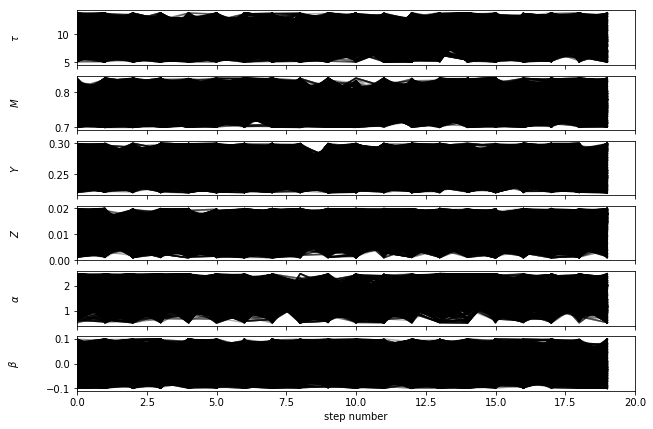

In [55]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.chain
labels = X_labels
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [52]:
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))

In [53]:
fig = corner.corner(samples, labels=X_labels)
fig.show()

AssertionError: I don't believe that you want more dimensions than samples!

In [ ]:
print(samples)
list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
    zip(*np.percentile(samples, [16, 50, 84], axis=0))))